## DTO

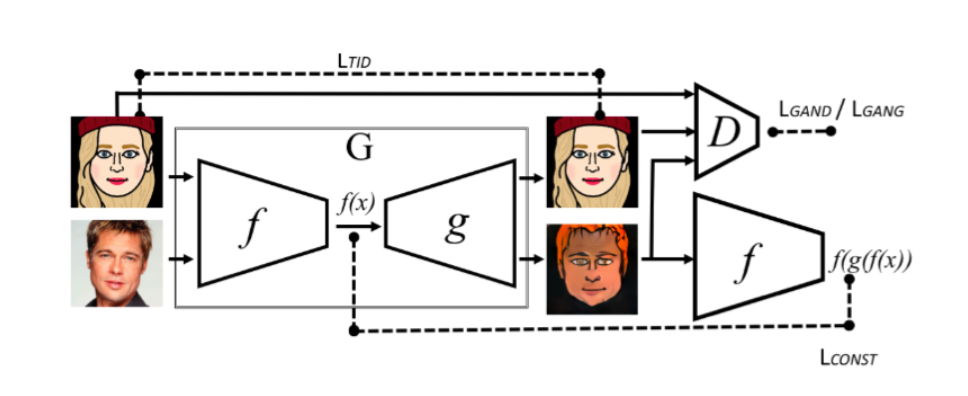

## Cycle Gan

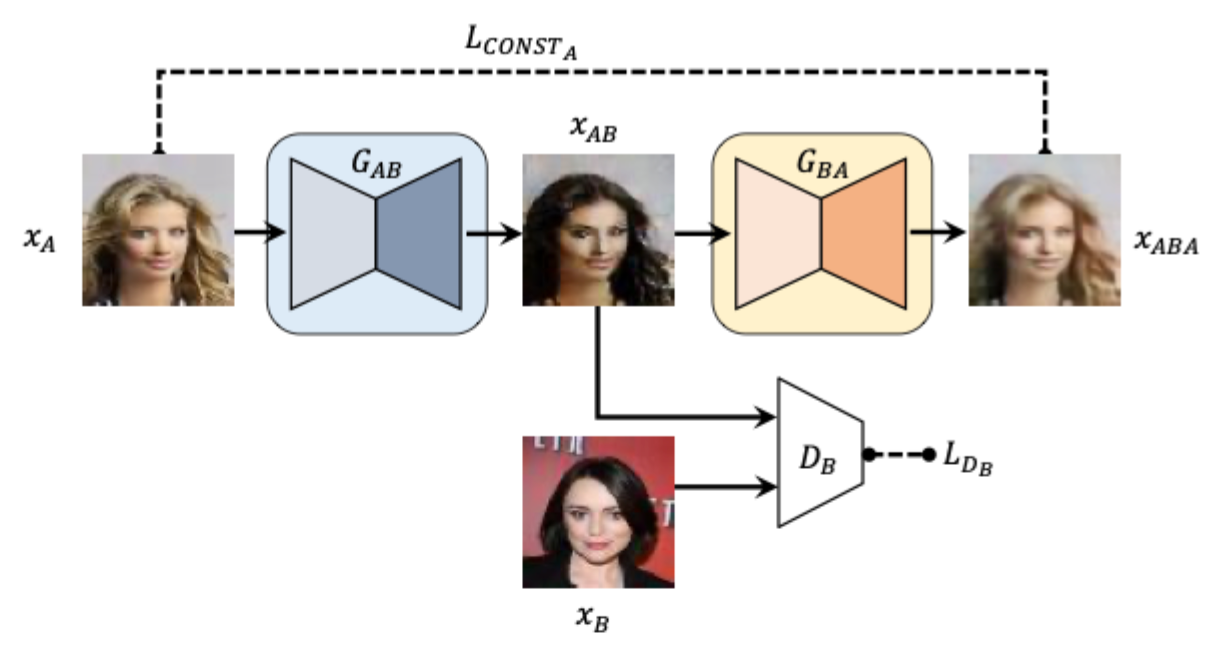

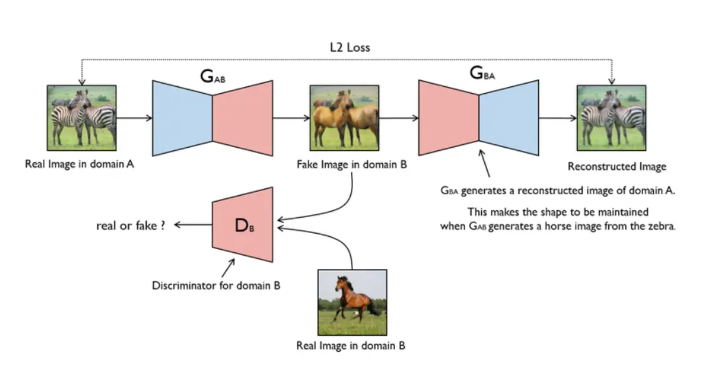

## My-GAN

生成器生成的图片有猫的特征，但是判别器认为生成的图片也有狗的特征。即生成的图片即是猫又是狗。

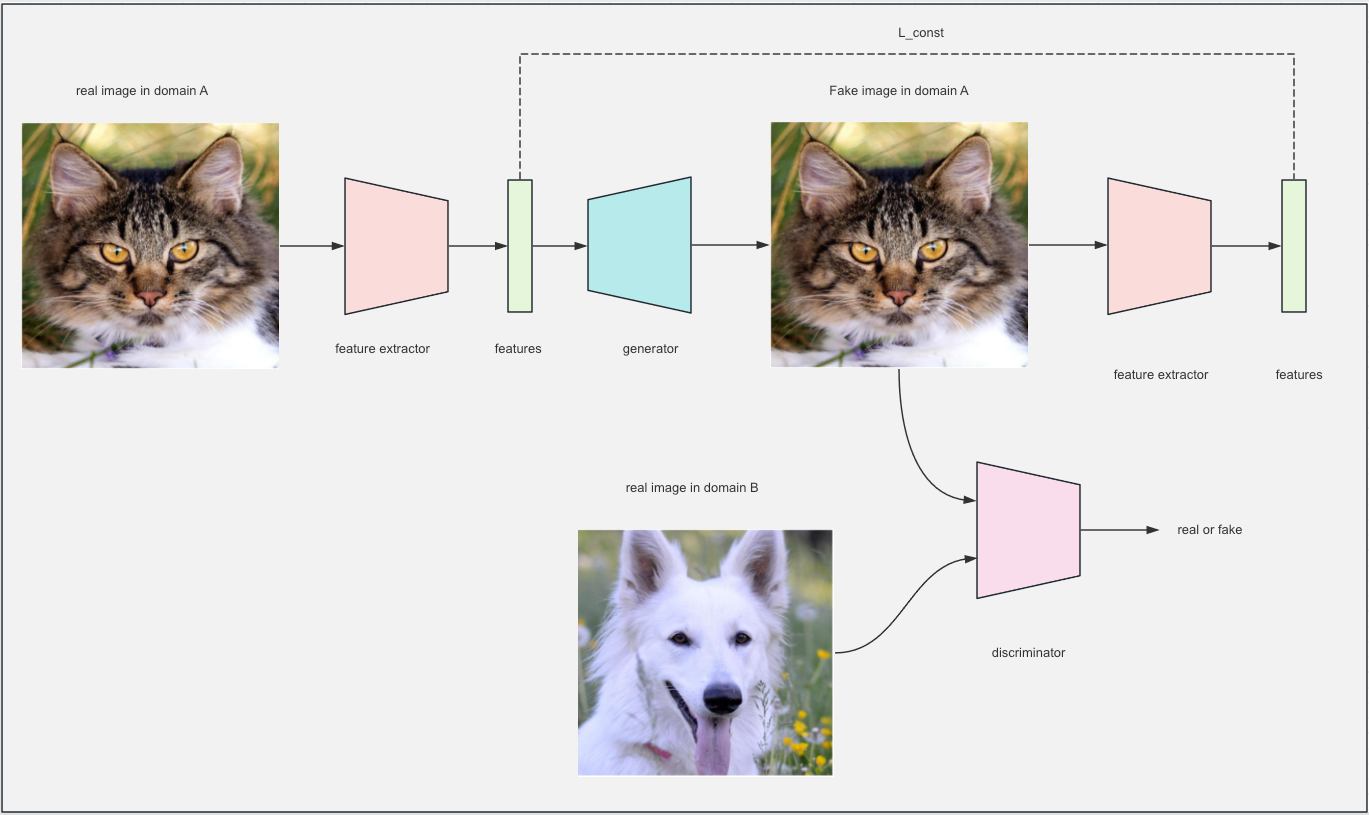

## Implementation

### Import requirment library

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses
import numpy as np
import time
from tensorflow.keras.regularizers import l2

### Load data

In [2]:
def load_images_as_rgb_matrices(folder_path, size=(32, 32)):
    rgb_matrices = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img_resized = img.resize(size)  
                rgb_matrix = np.array(img_resized.convert("RGB"))
                rgb_matrices.append(rgb_matrix)
    return rgb_matrices


In [3]:
cat_path = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/afhq/train/cat"
dog_path = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/afhq/train/dog"
val_cat_path = "/Users/dengkai/workspace/ucc/course/ucc/dissertation/Gan/kai/code/note/afhq/val/cat"

size=(128, 128)

cats = load_images_as_rgb_matrices(cat_path, size)
dogs = load_images_as_rgb_matrices(dog_path, size)
val_cats = load_images_as_rgb_matrices(val_cat_path, size)

In [4]:
def plot_images(image_list, title):
    fig, axes = plt.subplots(1, len(image_list), figsize=(15, 5))
    for ax, img in zip(axes, image_list):
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle(title)
    plt.show()

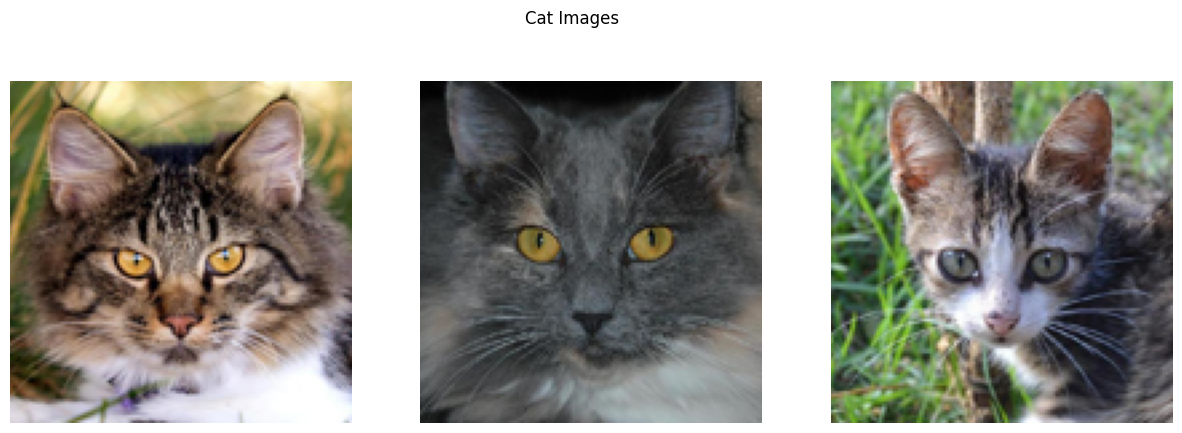

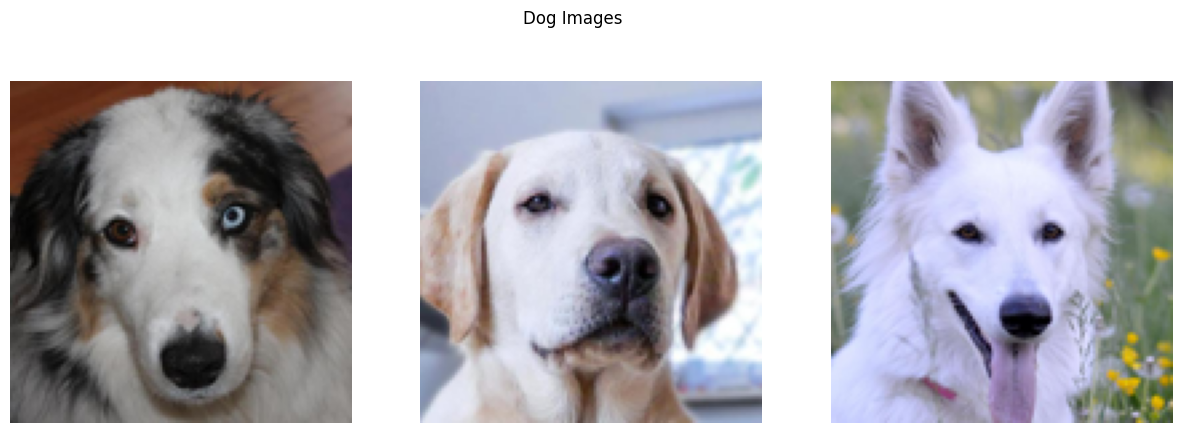

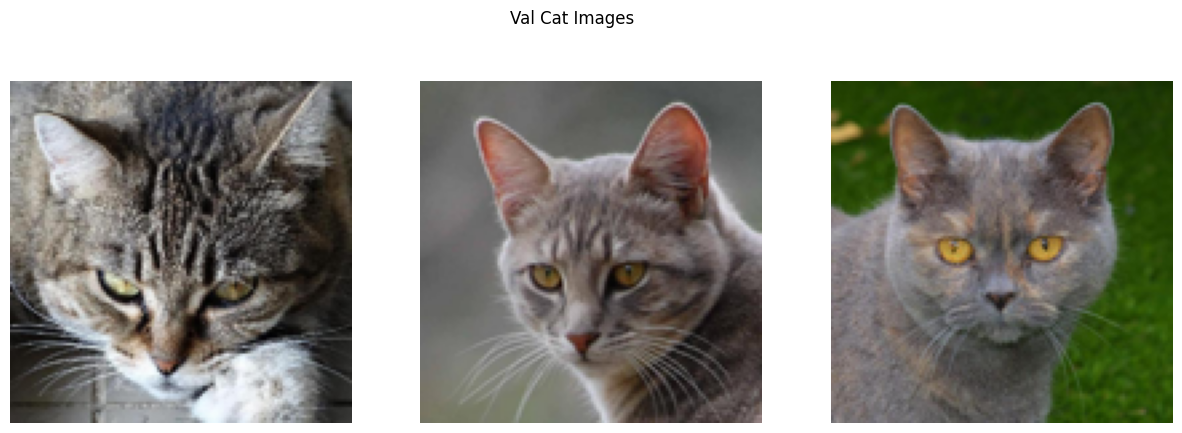

In [5]:
# plot
plot_images(cats[:3], 'Cat Images')
plot_images(dogs[:3], 'Dog Images')
plot_images(val_cats[:3], 'Val Cat Images')

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses
import numpy as np
import time
import matplotlib.pyplot as plt

# extract 32 dimension features

def build_feature_extractor(input_shape):
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    model = Model(input_img, x, name='feature_extractor')
    return model

def build_generator(input_shape):
    input_features = layers.Input(shape=(input_shape,))
    x = layers.Dense(32 * 32 * 128, kernel_regularizer=l2(0.1))(input_features)  
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)  
    x = layers.Reshape((32, 32, 128))(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=l2(0.1))(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)  
    x = layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)
    model = Model(input_features, x, name='generator')
    return model

def build_discriminator(input_shape):
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.1))(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=l2(0.1))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))(x)
    model = Model(input_img, x, name='discriminator')
    return model



input_shape = (128, 128, 3)

feature_extractor = build_feature_extractor(input_shape)
generator = build_generator(32) 
discriminator = build_discriminator(input_shape)

binary_crossentropy = losses.BinaryCrossentropy(from_logits=False)

feature_extractor_optimizer = tf.keras.optimizers.legacy.Adam(1e-5)
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1.2e-5)


def reconstruction_loss(original_features, generated_features):
    return tf.reduce_mean(tf.abs(original_features - generated_features))


@tf.function
def train_step(cat_images, dog_images):
    with tf.GradientTape(persistent=True) as tape:
       
        original_features = feature_extractor(cat_images, training=True)
        generated_images = generator(original_features, training=True)

        real_output = discriminator(dog_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        generated_features = feature_extractor(generated_images)

        gen_loss = binary_crossentropy(tf.ones_like(fake_output), fake_output)
        disc_loss = binary_crossentropy(tf.ones_like(real_output), real_output) + \
                    binary_crossentropy(tf.zeros_like(fake_output), fake_output)
        recon_loss = reconstruction_loss(original_features, generated_features) * 10
        
    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_feature_extractor = tape.gradient(recon_loss, feature_extractor.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    feature_extractor_optimizer.apply_gradients(zip(gradients_of_feature_extractor, feature_extractor.trainable_variables))

    return gen_loss, disc_loss, recon_loss

def train(cat_dataset, dog_dataset, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        total_recon_loss = 0
        num_batches = 0

        for cat_images, dog_images in zip(cat_dataset, dog_dataset):
            gen_loss, disc_loss, recon_loss = train_step(cat_images, dog_images)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            total_recon_loss += recon_loss
            num_batches += 1

        avg_gen_loss = total_gen_loss / num_batches
        avg_disc_loss = total_disc_loss / num_batches
        avg_recon_loss = total_recon_loss / num_batches
        epoch_time = time.time() - start_time

        print(f'Epoch {epoch + 1}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, Time: {epoch_time:.2f} sec')

### Training model

In [7]:
l = len(dogs)

In [8]:
batch_size = 256
cat_dataset = tf.data.Dataset.from_tensor_slices(cats[:l]).batch(batch_size)
dog_dataset = tf.data.Dataset.from_tensor_slices(dogs).batch(batch_size)

epochs = 100
train(cat_dataset, dog_dataset, epochs)

Epoch 1, Gen Loss: 0.8813, Disc Loss: 1.6205, Recon Loss: 3.9403, Time: 60.91 sec
Epoch 2, Gen Loss: 0.8914, Disc Loss: 1.6004, Recon Loss: 3.8555, Time: 59.99 sec
Epoch 3, Gen Loss: 0.8769, Disc Loss: 1.6381, Recon Loss: 3.7923, Time: 60.47 sec
Epoch 4, Gen Loss: 0.8830, Disc Loss: 1.6640, Recon Loss: 3.7341, Time: 60.66 sec
Epoch 5, Gen Loss: 0.8923, Disc Loss: 1.6790, Recon Loss: 3.6800, Time: 60.43 sec
Epoch 6, Gen Loss: 0.9129, Disc Loss: 1.6345, Recon Loss: 3.6275, Time: 59.87 sec
Epoch 7, Gen Loss: 0.9238, Disc Loss: 1.6501, Recon Loss: 3.5811, Time: 60.21 sec
Epoch 8, Gen Loss: 0.9774, Disc Loss: 1.5713, Recon Loss: 3.5378, Time: 60.99 sec
Epoch 9, Gen Loss: 1.0022, Disc Loss: 1.5796, Recon Loss: 3.4978, Time: 60.37 sec
Epoch 10, Gen Loss: 1.0512, Disc Loss: 1.5033, Recon Loss: 3.4606, Time: 60.35 sec
Epoch 11, Gen Loss: 1.1092, Disc Loss: 1.4579, Recon Loss: 3.4152, Time: 60.11 sec
Epoch 12, Gen Loss: 1.1560, Disc Loss: 1.3941, Recon Loss: 3.3728, Time: 60.14 sec
Epoch 13, Gen

Epoch 100, Gen Loss: 3.4235, Disc Loss: 0.2247, Recon Loss: 1.8368, Time: 57.88 sec


### Test

In [9]:
def normalize_and_squeeze(image):
    normalized_images = tf.clip_by_value((image + 1.0) * 127.5, 0.0, 255.0)
    normalized_images = tf.cast(normalized_images, tf.uint8)
    image_data_squeezed = tf.squeeze(normalized_images, axis=0)
    return image_data_squeezed

def test_model(generator, feature_extractor, test_images, num_images=5):
    plt.figure(figsize=(20, 10))
    
    for i in range(num_images):
        test_image = test_images[np.random.randint(0, len(test_images))]
        test_image = np.expand_dims(test_image, axis=0) 

        extracted_features = feature_extractor(test_image)

        generated_image = generator(extracted_features, training=False)

        generated_image = normalize_and_squeeze(generated_image)

        plt.subplot(2, num_images, i + 1)
        plt.title("Original Image")
        plt.imshow(test_image[0].astype('uint8'))  

        plt.subplot(2, num_images, num_images + i + 1)
        plt.title("Generated Image")
        plt.imshow(generated_image)
    
    plt.show()


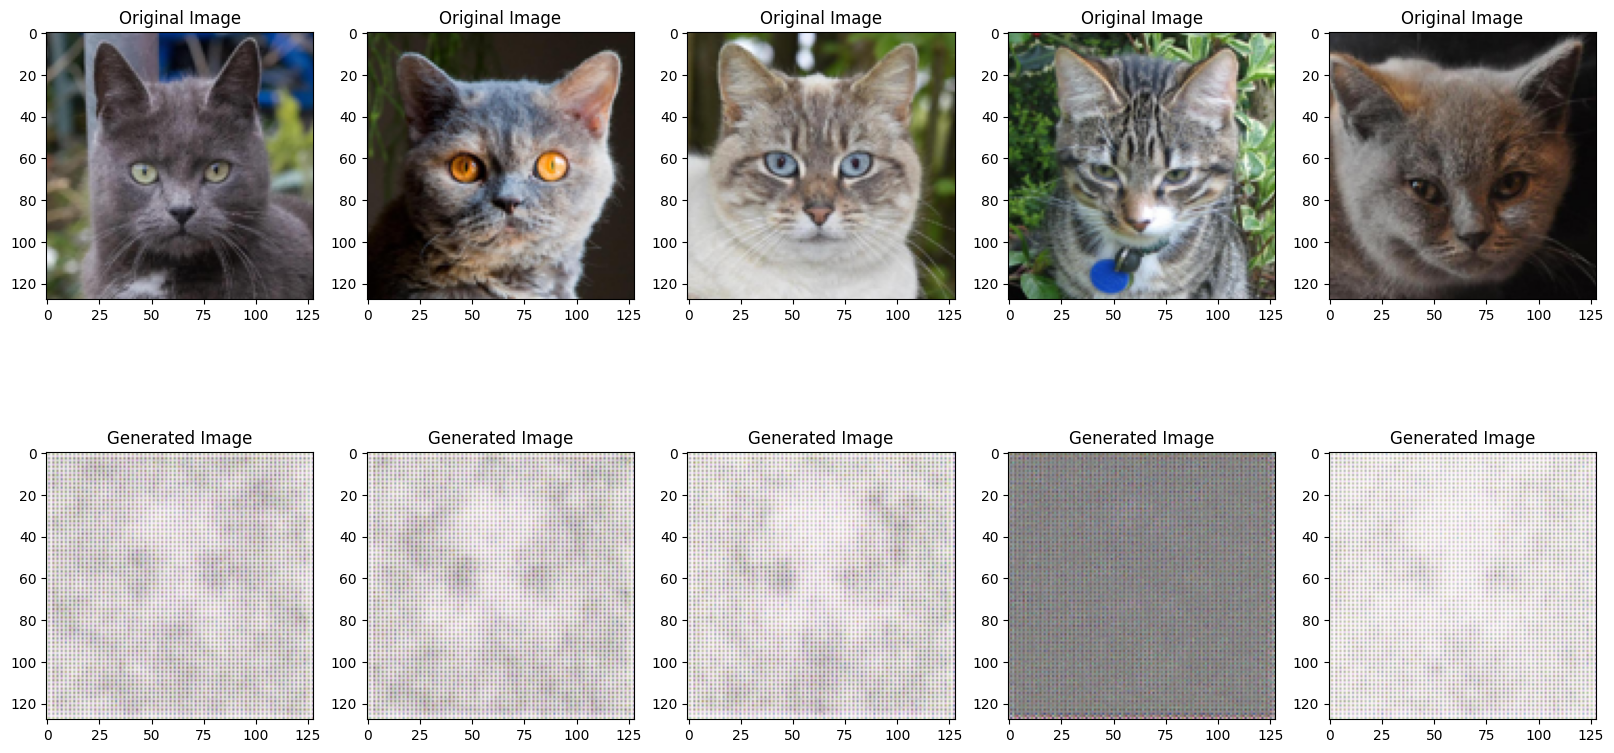

In [10]:
test_model(generator, feature_extractor, val_cats)